In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from conformal_utils import *

%load_ext autoreload
%autoreload 2

### Inputs
1. Class-specific qhats
2. Conformal scores (e.g., softmax vectors) and ground truth labels to evaluate on 

In [70]:
# qhats = np.load('.cache/quantiles_06-08-22.npy') # qhats estimated using oracle prior
qhats = np.load('.cache/conformalized_qhats.npy') # Conformalized qhats estimated using oracle prior

In [6]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [7]:
scores = 1 - softmax_scores

In [21]:
%%time
# Get split of data not used for calibration to use for validation
calib_scores, calib_labels, val_scores, val_labels = split_X_and_y(scores, labels, 20, num_classes=1000, seed=0)

CPU times: user 3.39 s, sys: 1min 53s, total: 1min 56s
Wall time: 1min 57s


### Evaluate

In [71]:
preds = create_cb_prediction_sets(val_scores, qhats)
# cb_preds = create_cb_prediction_sets(scores, qhats_old)

In [72]:
marginal_cov = compute_coverage(val_labels, preds)
print(f'Marginal coverage of EB-CB: {marginal_cov*100:.2f}%')

# Using unconformalized qhats: 90.70%

Marginal coverage of EB-CB: 90.10%


In [73]:
class_specific_cov = compute_class_specific_coverage(val_labels, preds)

In [80]:
# Get baselines for comparison
alpha = 0.1 # Should be the same alpha used for qhats that we loaded in
print(f'(Desired marginal coverage: {(1-alpha) * 100:.1f}%)')

# A) Vanilla conformal
vanilla_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha)
vanilla_preds = create_prediction_sets(val_scores, vanilla_qhat)

marginal_cov = compute_coverage(val_labels, vanilla_preds)
print(f'Marginal coverage of Vanilla: {marginal_cov*100:.2f}%')
vanilla_class_specific_cov = compute_class_specific_coverage(val_labels, vanilla_preds)

# B) Naive class-balanced
naivecb_qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha)
naivecb_preds = create_cb_prediction_sets(val_scores, naivecb_qhats)

naivecb_marginal_cov = compute_coverage(val_labels, naivecb_preds)
print(f'Marginal coverage of Naive CB: {naivecb_marginal_cov*100:.2f}%')
naivecb_class_specific_cov = compute_class_specific_coverage(val_labels, naivecb_preds)

(Desired marginal coverage: 90.0%)
Marginal coverage of Vanilla: 90.28%
Marginal coverage of Naive CB: 90.97%


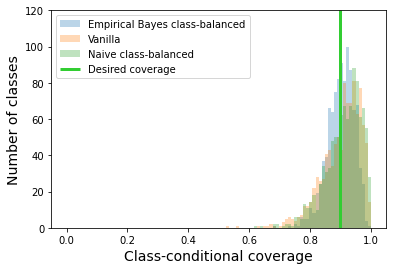

In [81]:
bins = np.linspace(0,1,100)
plt.hist(class_specific_cov, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
plt.hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
plt.hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

plt.vlines(1-alpha, 0, 120, label='Desired coverage', color='limegreen', linewidth=3)
plt.ylim(0,120)

plt.ylabel('Number of classes', fontsize=14)
plt.xlabel('Class-conditional coverage', fontsize=14)
plt.legend()
plt.show()

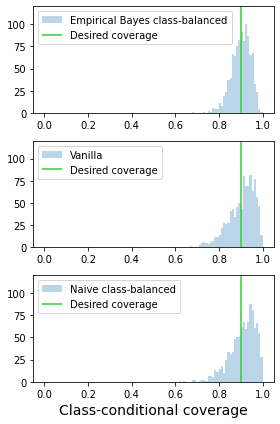

In [82]:
# The same histograms as above, except on separate plots
fig, axs = plt.subplots(3,1, figsize=(4, 6))

bins = np.linspace(0, 1, 100)
axs[0].hist(class_specific_cov, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
axs[1].hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
axs[2].hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

for i in range(3):
    axs[i].vlines(1-alpha, 0, 120, label='Desired coverage', color='limegreen')
    axs[i].set_ylim(0, 120)
    axs[i].legend(loc='upper left')

plt.xlabel('Class-conditional coverage', fontsize=14)
plt.tight_layout()

In [89]:
# Compute l1 distance between desired and realized coverage
l1_dist = np.sum(np.abs(class_specific_cov - (1 - alpha)))
vanilla_l1_dist = np.sum(np.abs(vanilla_class_specific_cov - (1 - alpha)))
naivecb_l1_dist = np.sum(np.abs(naivecb_class_specific_cov - (1 - alpha)))

print(f'[EB-CB] L1 distance between desired and realized class-cond. coverage: {l1_dist:.3f}')
print(f'[Vanilla] L1 distance between desired and realized class-cond. coverage: {vanilla_l1_dist:.3f}')
print(f'[Naive-CB] L1 distance between desired and realized class-cond. coverage: {naivecb_l1_dist:.3f}')

print("\nNote: The average magnitude of deviation from the desired coverage is L1 dist/1000")

[EB-CB] L1 distance between desired and realized class-cond. coverage: 35.081
[Vanilla] L1 distance between desired and realized class-cond. coverage: 51.524
[Naive-CB] L1 distance between desired and realized class-cond. coverage: 49.040

Note: The average magnitude of deviation from the desired coverage is L1 dist/1000


In [83]:
# Compute number of classes that are drastically undercovered (<80%)
thresh = 0.8

num_undercovered = np.sum(class_specific_cov < thresh)
vanilla_num_undercovered = np.sum(vanilla_class_specific_cov < thresh)
naivecb_num_undercovered = np.sum(naivecb_class_specific_cov < thresh)

print(f'[EB-CB] Number of classes that have less than 80% coverage:', num_undercovered)
print(f'[Vanilla] Number of classes that have less than 80% coverage:', 
      vanilla_num_undercovered)
print(f'[Naive-CB] Number of classes that have less than 80% coverage:', 
      naivecb_num_undercovered)

# Usign unconformalized qhats: [EB-CB] Number of classes that have less than 80% coverage: 15

[EB-CB] Number of classes that have less than 80% coverage: 22
[Vanilla] Number of classes that have less than 80% coverage: 72
[Naive-CB] Number of classes that have less than 80% coverage: 56


In [78]:
avg_set_size = compute_avg_set_size(preds)
vanilla_avg_set_size = compute_avg_set_size(vanilla_preds)
naivecb_avg_set_size = compute_avg_set_size(naivecb_preds)

print(f'[EB-CB] Average size of prediction set: {avg_set_size:.2f}')
print(f'[Vanilla] Average size of prediction set: {vanilla_avg_set_size:.2f}')
print(f'[Naive-CB] Average size of prediction set: {naivecb_avg_set_size:.2f}')

# Using unconformalized qhats: [EB-CB] Average size of prediction set: 2.99

[EB-CB] Average size of prediction set: 2.68
[Vanilla] Average size of prediction set: 1.99
[Naive-CB] Average size of prediction set: 10.05


[EB-CB] Max prediction set size: 25
[Vanilla] Max prediction set size: 12
[Naive-CB] Max prediction set size: 90


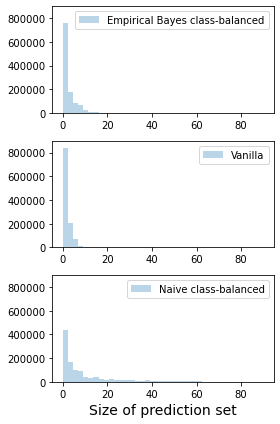

In [84]:
# Visualization of set sizes
set_sizes = [len(x) for x in preds]
vanilla_set_sizes = [len(x) for x in vanilla_preds]
naivecb_set_sizes = [len(x) for x in naivecb_preds]

print(f'[EB-CB] Max prediction set size: {np.max(set_sizes)}')
print(f'[Vanilla] Max prediction set size: {np.max(vanilla_set_sizes)}')
print(f'[Naive-CB] Max prediction set size: {np.max(naivecb_set_sizes)}')

fig, axs = plt.subplots(3,1, figsize=(4, 6))

bins = np.linspace(0, 90, 40)
axs[0].hist(set_sizes, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
axs[1].hist(vanilla_set_sizes, bins=bins, label="Vanilla", alpha=.3)
axs[2].hist(naivecb_set_sizes, bins=bins, label="Naive class-balanced", alpha=.3)

for i in range(3):
    axs[i].legend()
    axs[i].set_ylim(0, 900000)

plt.xlabel('Size of prediction set', fontsize=14)
plt.tight_layout()

# Using unconformalized qhats: [EB-CB] Max prediction set size: 28